# Great Expectations: demo part 1


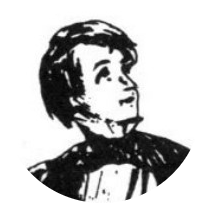


Please set yourself up by:
- Cloning the git repository from GitHub: https://github.com/heineken-advanced-analytics/great-expectation-workshop-pydata.git (shared through chat).
- Read the README for installation instructions.
- Navigate to this workshop: ```workshop-pydata-part1.ipynb```.

In this part we cover:
- How we can implement a simple data validation pipeline with GE through its API.
- Which expectations are built in and how to use them.
- How custom expectations can be implemented.

In [ ]:
from typing import Dict, List
import pandas as pd
import great_expectations as ge
from great_expectations.dataset import MetaPandasDataset, PandasDataset

## Why we need Great Expectations

A possible validation pipeline without GE.

Our validation goal is to:
- Construct a validation pipeline that checks the dataset, 
- potentially other datasets coming in over time,
- from a given data schema.

In [ ]:
# We start by loading the file that we want to check.
filepath = "data/weather_brasil_201301.csv"
weather_data_df = pd.read_csv(filepath)

In [ ]:
# Familiarize with the data
weather_data_df.head()

In [ ]:
# Check function to see if pipeline would continue or break given the validation result.
def continue_pipeline(validation_result: bool):
    if validation_result:
        print("Pipeline continues.")
    else:
        print("Pipeline breaks.")

## A data validation pipeline with Great Expectations


In [ ]:
## GE can work with pandas, by extending the pandas DataFrame class
weather_data_batch = ge.read_csv(filepath)
print(type(weather_data_batch))

In [ ]:
weather_data_batch.head()

Now we can simply attach some built-in expectations of Great Expectations to our dataframe.

In [ ]:
# Name expectations for each column.
required_columns = [
        "id", "elevation", "lat", "lon", "code", "city",
        "timestamp",
        "precip", "air_pres", "solar_rad", "temp", "rel_humid", "wind_speed",
]

In [8]:
weather_data_batch.expect_table_columns_to_match_ordered_list(
    column_list=required_columns
);

In [9]:
# And simply validate the batch against the expectations.
validation_result = weather_data_batch.validate()
print(validation_result)

{
  "evaluation_parameters": {},
  "statistics": {
    "evaluated_expectations": 1,
    "successful_expectations": 1,
    "unsuccessful_expectations": 0,
    "success_percent": 100.0
  },
  "success": true,
  "results": [
    {
      "expectation_config": {
        "expectation_type": "expect_table_columns_to_match_ordered_list",
        "kwargs": {
          "column_list": [
            "id",
            "elevation",
            "lat",
            "lon",
            "code",
            "city",
            "timestamp",
            "precip",
            "air_pres",
            "solar_rad",
            "temp",
            "rel_humid",
            "wind_speed"
          ],
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "success": true,
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "observed_value": [
          "id",
          "elevation"

In [10]:
continue_pipeline(validation_result["success"])

Pipeline continues.


In [11]:
weather_data_batch.expect_column_values_to_be_between(
    column="temp", min_value=-30, max_value=60
);

In [12]:
# 'domain specific expectatoins, needing domain knowledge'
# <brasilian-specific expectation>

In [13]:
continue_pipeline(validation_result["success"])

Pipeline continues.


## Try it yourself!

- Access the documentation: ```shift-tab``` on ```weather_data_batch.expect_```.
- Or have a look at the glossary: https://docs.greatexpectations.io/en/0.11.2/reference/glossary_of_expectations.html#expectation-glossary (share link through chat).
- Please share your expectation through the chat!

We'll continue in a few minutes.

In [14]:
# <weather_data_batch.expect_>

In [15]:
weather_data_batch.expect_column_max_to_be_between(
    column="lon", min_value=-71, max_value=6, 
);

In [16]:
validation_result = weather_data_batch.validate()
continue_pipeline(validation_result)

Pipeline continues.


Stay tuned for part 2, to learn how you can be more flexible towards certain expectations

## Only those built-in expectations?

If we want, we can specify custom logic and add it as an expectation to our batch. 

We overdid ourselves and created an expectation checking if the given columns hold unique combinations of values.

In [17]:
weather_data_batch.head()

,id,elevation,lat,lon,code,city,timestamp,precip,air_pres,solar_rad,temp,rel_humid,wind_speed
0,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 00:00:00,NaN,983.1,NaN,30.1,44.0,2.9
1,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 01:00:00,NaN,983.4,NaN,30.0,43.0,1.5
2,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 02:00:00,NaN,983.5,NaN,30.5,40.0,1.9
3,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 03:00:00,NaN,983.9,NaN,29.8,45.0,2.5
4,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 04:00:00,NaN,983.8,NaN,28.7,54.0,3.0


In [18]:
class CustomPandasDataset(PandasDataset):
    
    # setting the _data_asset_type is not required,
    # but helps GE interpreting this as a custom expectation.
    _data_asset_type = "CustomPandasDataset"

    @MetaPandasDataset.multicolumn_map_expectation
    def expect_columns_combination_to_be_unique(
        self, 
        column_list,
        *,
        index=None
    ):
        # A pandas series with a boolean per row is the required output
        # for this multicolumn map expectation format.
        result = pd.Series()

        grouped_df = column_list.groupby(index if index else column_list.columns[0])

        for index, group in grouped_df:
            if not (group.nunique(axis=0) == 1).all(axis=None):
                result = result.append(
                    pd.Series([False for x in range(len(group))]), ignore_index=True
                )
            else:
                result = result.append(
                    pd.Series([True for x in range(len(group))]), ignore_index=True
                )
    
        return result

In [19]:
weather_data_batch = ge.read_csv(filepath, dataset_class=CustomPandasDataset)

In [20]:
weather_data_batch.head()

,id,elevation,lat,lon,code,city,timestamp,precip,air_pres,solar_rad,temp,rel_humid,wind_speed
0,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 00:00:00,NaN,983.1,NaN,30.1,44.0,2.9
1,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 01:00:00,NaN,983.4,NaN,30.0,43.0,1.5
2,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 02:00:00,NaN,983.5,NaN,30.5,40.0,1.9
3,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 03:00:00,NaN,983.9,NaN,29.8,45.0,2.5
4,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 04:00:00,NaN,983.8,NaN,28.7,54.0,3.0


In [21]:
weather_data_batch.expect_table_columns_to_match_ordered_list(
    required_columns
);

In [22]:
weather_data_batch.expect_column_values_to_be_between(
    column="temp", min_value=-30, max_value=60
);

In [23]:
# We check if a weather station always has the same lat/lon.
weather_data_batch.expect_columns_combination_to_be_unique(
    ["id", "lat", "lon"]
);

In [24]:
validation_result = weather_data_batch.validate()
# Now we see the custom expectation in this validation result.
print(validation_result)

{
  "evaluation_parameters": {},
  "statistics": {
    "evaluated_expectations": 3,
    "successful_expectations": 3,
    "unsuccessful_expectations": 0,
    "success_percent": 100.0
  },
  "success": true,
  "results": [
    {
      "expectation_config": {
        "expectation_type": "expect_table_columns_to_match_ordered_list",
        "kwargs": {
          "column_list": [
            "id",
            "elevation",
            "lat",
            "lon",
            "code",
            "city",
            "timestamp",
            "precip",
            "air_pres",
            "solar_rad",
            "temp",
            "rel_humid",
            "wind_speed"
          ],
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "success": true,
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "observed_value": [
          "id",
          "elevation"

In [25]:
continue_pipeline(validation_result["success"])

Pipeline continues.


In [26]:
## Let's double check if it works by introducing an error here.

In [27]:
weather_data_batch.head(n=2)

,id,elevation,lat,lon,code,city,timestamp,precip,air_pres,solar_rad,temp,rel_humid,wind_speed
0,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 00:00:00,NaN,983.1,NaN,30.1,44.0,2.9
1,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 01:00:00,NaN,983.4,NaN,30.0,43.0,1.5


In [28]:
weather_data_batch.at[0, "lat"] = 88

In [29]:
weather_data_batch.head(n=2)

,id,elevation,lat,lon,code,city,timestamp,precip,air_pres,solar_rad,temp,rel_humid,wind_speed
0,178,237.0,88.000000,-38.311583,A333,São Gonçalo,2013-01-01 00:00:00,NaN,983.1,NaN,30.1,44.0,2.9
1,178,237.0,-6.835777,-38.311583,A333,São Gonçalo,2013-01-01 01:00:00,NaN,983.4,NaN,30.0,43.0,1.5


In [30]:
weather_data_batch.validate()

{
  "evaluation_parameters": {},
  "statistics": {
    "evaluated_expectations": 3,
    "successful_expectations": 2,
    "unsuccessful_expectations": 1,
    "success_percent": 66.66666666666666
  },
  "success": false,
  "results": [
    {
      "expectation_config": {
        "expectation_type": "expect_table_columns_to_match_ordered_list",
        "kwargs": {
          "column_list": [
            "id",
            "elevation",
            "lat",
            "lon",
            "code",
            "city",
            "timestamp",
            "precip",
            "air_pres",
            "solar_rad",
            "temp",
            "rel_humid",
            "wind_speed"
          ],
          "result_format": "BASIC"
        },
        "meta": {}
      },
      "success": true,
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "result": {
        "observed_value": [
          "id",
        

## So far the basic flow...


We have seen:
- how we can use Great Expectations to implement built-in expectations, 
- extend functionality with custom expectations, 
- run validations against those expectations, and 
- we inspected the validation output.

Unfortuantely, it is not possible to easily validate incoming batches over time, you would need to add these expectations to a batch every time.

We also have not demonstrated those **neat automated docs** and **fancy validation reports**.

Please stay tuned as in part 2 of this workshop, Joost will demonstrate that through the CLI!